# XGBoost Classifier (and Random Forest Classifier)

In [1]:
import platform
import warnings

# For warnings in xgboost.sklearn
warnings.simplefilter(action="ignore", category=FutureWarning)

import time

import matplotlib.pyplot as plt
import numpy
from matplotlib.colors import ListedColormap
from sklearn.datasets import fetch_openml, make_circles
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost.sklearn import XGBClassifier as SklearnXGBClassifier

from concrete.ml.sklearn import RandomForestClassifier as ConcreteRandomForestClassifier
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

%matplotlib inline

### Define if you want to run XGBoost or Random Forest classifier

In [2]:
which_classifier = "XGBoost"
# which_classifier = "RF"

if which_classifier == "XGBoost":
    sklearn_classifier = SklearnXGBClassifier
    concrete_classifier = ConcreteXGBClassifier
    fit_extra_param = {"eval_metric": "logloss"}
else:
    sklearn_classifier = SklearnRandomForestClassifier
    concrete_classifier = ConcreteRandomForestClassifier
    fit_extra_param = {}

### Let's define some data to classify

In [3]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.6, random_state=0)

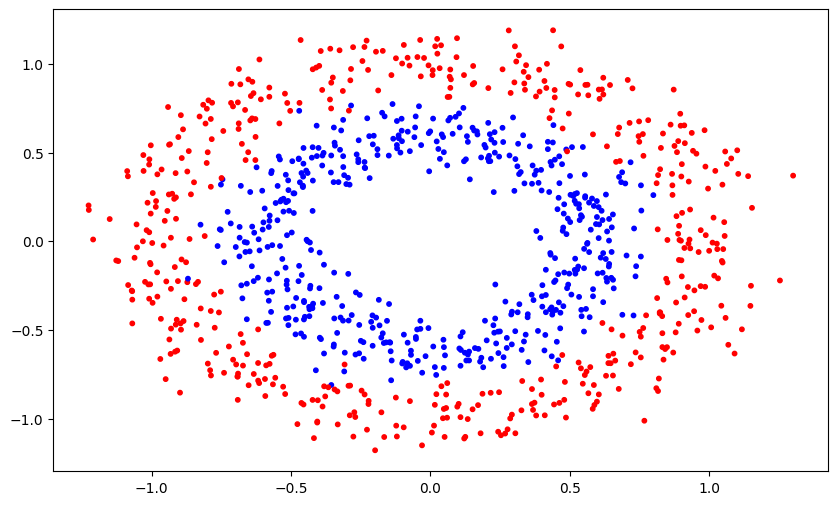

In [4]:
# Define the figure size and color
plt.figure(figsize=(10, 6))
cm_bright = ListedColormap(["#FF0000", "#FFFFFF", "#0000FF"])

plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=cm_bright)
plt.show()

In [5]:
n_estimators = 50
max_depth = 4
n_bits = 6

In [6]:
n_jobs_xgb = 1
n_jobs_gridsearch = -1

# There are problems on macOS with multi-jobs in GridSearch so let's switch
if platform.system() == "Darwin":
    n_jobs_xgb = -1
    n_jobs_gridsearch = 1

### This is how to classify with scikit-learn

In [7]:
sklearn_clf = sklearn_classifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs_xgb)
sklearn_clf.fit(X, y, **fit_extra_param);

### And this is how to classify with Concrete-ML: pretty much the same

In [8]:
concrete_clf = concrete_classifier(
    n_bits=n_bits, n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs_xgb
)
concrete_clf.fit(X, y);

### Now, let's see the classifications

In [9]:
def plot_contour(clf, X, y):
    # Create a grid will lots of point to plot the contour of the decision function
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    grid_x, grid_y = numpy.meshgrid(
        numpy.arange(x_min, x_max, 0.1), numpy.arange(y_min, y_max, 0.1)
    )

    # Predict the function value on the grid
    grid_z = clf.predict_proba(numpy.c_[grid_x.ravel(), grid_y.ravel()])[:, 1]

    # grid_z = clf.predict(numpy.c_[grid_x.ravel(), grid_y.ravel()])
    grid_z = grid_z.reshape(grid_x.shape)

    # Define the plot size
    plt.figure(figsize=(10, 6))

    # Plot the contour and training examples
    plt.contourf(grid_x, grid_y, grid_z, cmap=cm_bright, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=cm_bright)
    plt.show()

With scikit-learn

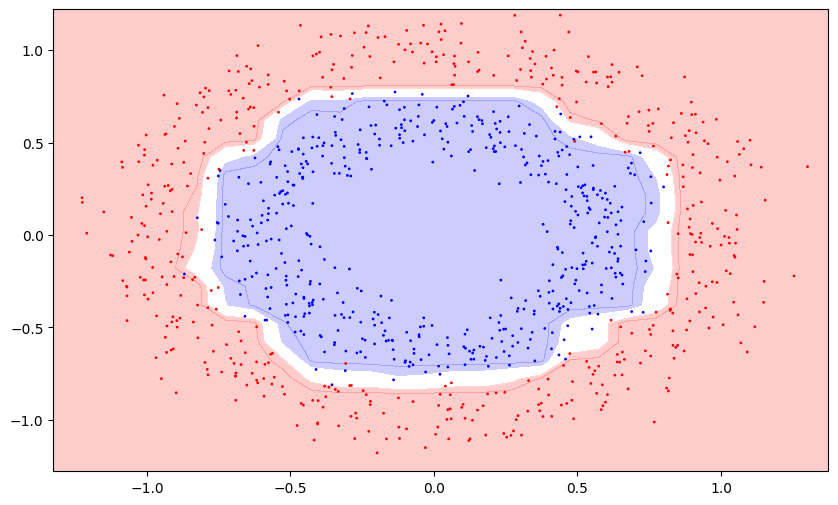

In [10]:
plot_contour(sklearn_clf, X, y)

And with Concrete-ML

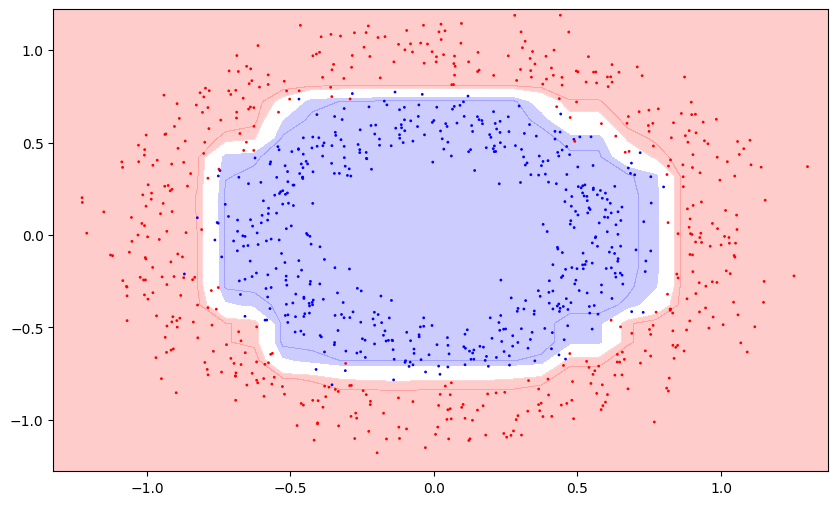

In [11]:
plot_contour(concrete_clf, X, y)

### And now, on the diabetes datasets

In [12]:
X, y = fetch_openml(name="diabetes", as_frame=False, cache=True, return_X_y=True)
y[y == "tested_positive"] = 1
y[y == "tested_negative"] = 0
y = y.astype(numpy.int)

In [13]:
# Create scorer with the MCC metric
grid_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
n_estimators_list = [1, 5, 10, 20] + [20 * i for i in range(2, 11)] + [50 * i for i in range(5, 11)]

In [14]:
param_grid = {
    "n_bits": [6],
    "max_depth": [2],
    "n_estimators": n_estimators_list,
}
concrete_clf = concrete_classifier(n_jobs=n_jobs_xgb)
gs_concrete = GridSearchCV(
    concrete_clf,
    param_grid,
    cv=5,
    scoring=grid_scorer,
    error_score="raise",
    verbose=1,
    n_jobs=n_jobs_gridsearch,
).fit(X, y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


In [15]:
warnings.filterwarnings("ignore")
param_grid = {
    "max_depth": [2],
    "n_estimators": n_estimators_list,
}
sklearn_clf = sklearn_classifier(n_jobs=n_jobs_xgb)
gs_sklearn = GridSearchCV(
    sklearn_clf,
    param_grid,
    cv=5,
    scoring=grid_scorer,
    error_score="raise",
    verbose=1,
    n_jobs=n_jobs_gridsearch,
).fit(X, y, **fit_extra_param)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


In [16]:
# Print mean time fit and std time fit for both models
print(
    f"Mean time fit sklearn: {numpy.mean(gs_sklearn.cv_results_['mean_fit_time']):.2f}s,"
    f" std time fit sklearn: {numpy.std(gs_sklearn.cv_results_['mean_fit_time']):.2f}s"
)
print(
    f"Mean time fit concrete: {numpy.mean(gs_concrete.cv_results_['mean_fit_time']):.2f}s,"
    f"std time fit concrete: {numpy.std(gs_concrete.cv_results_['mean_fit_time']):.2f}s"
)

# Print best score for both models
print(f"Best MCC score sklearn: {gs_sklearn.best_score_:.2f}")
print(f"Best MCC score concrete: {gs_concrete.best_score_:.2f}")

Mean time fit sklearn: 1.03s, std time fit sklearn: 0.71s
Mean time fit concrete: 3.17s,std time fit concrete: 1.17s
Best MCC score sklearn: 0.48
Best MCC score concrete: 0.52


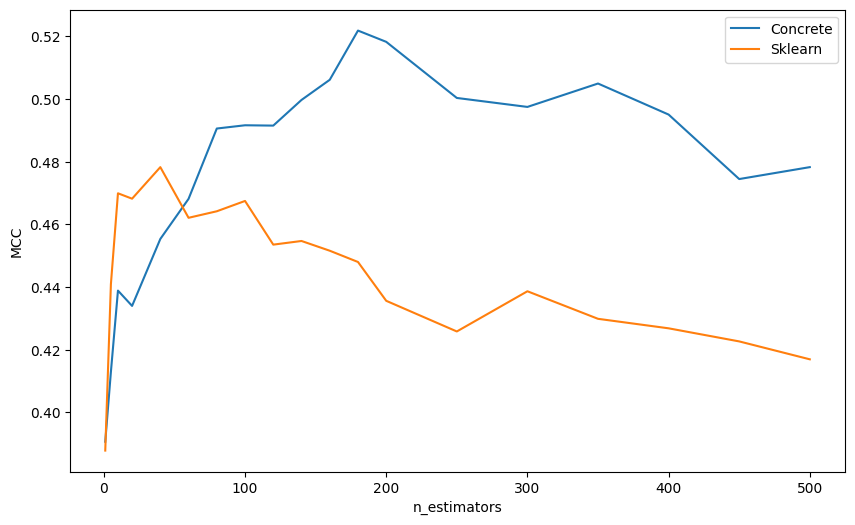

In [17]:
# Define the figure size
plt.figure(figsize=(10, 6))

# Plot the mean_test_score of both model along the n_estimators hyper parameter
plt.plot(
    gs_concrete.cv_results_["param_n_estimators"],
    gs_concrete.cv_results_["mean_test_score"],
    label="Concrete",
)
plt.plot(
    gs_sklearn.cv_results_["param_n_estimators"],
    gs_sklearn.cv_results_["mean_test_score"],
    label="Sklearn",
)
plt.xlabel("n_estimators")
plt.ylabel("MCC")
plt.legend()
plt.show()

### FHE Execution

Now that we have the best hyper parameters for our XGBoost model, we want to use it in FHE.

In [18]:
# Get best hyper parameters out of gs_concrete
best_params_concrete = gs_concrete.best_params_
print(f"Best parameters for Concrete {which_classifier}: {best_params_concrete}")
best_params_sklearn = gs_sklearn.best_params_
print(f"Best parameters for Sklearn {which_classifier}: {best_params_sklearn}")

# Train concrete and sklearn xgb  with best hyper parameters
concrete_clf = concrete_classifier(**best_params_concrete, n_jobs=n_jobs_xgb)
sklearn_clf = sklearn_classifier(**best_params_sklearn, n_jobs=n_jobs_xgb)

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
concrete_clf.fit(X_train, y_train)
sklearn_clf.fit(X_train, y_train, **fit_extra_param)

Best parameters for Concrete XGBoost: {'max_depth': 2, 'n_bits': 6, 'n_estimators': 180}
Best parameters for Sklearn XGBoost: {'max_depth': 2, 'n_estimators': 40}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=40, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [19]:
# Compile the model using the training data (this can take several minutes)
circuit = concrete_clf.compile(X_train)

In [20]:
# Generate the key
print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for an 6-bit circuit


In [21]:
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 485.99 seconds


In [22]:
# Now that the model is compiled, we can compute some examples in FHE.
# We will use 10 examples from the test set.
n_sample_to_test_fhe = 10

# Set numpy random seed
numpy.random.seed(42)

# Pick n_sample_to_test_fhe random samples from the test set
idx_test = numpy.random.choice(X_test.shape[0], n_sample_to_test_fhe, replace=False)
X_test_fhe = X_test[idx_test]
y_test_fhe = y_test[idx_test]

# Get the equivalent sklearn (fp32) predictions
y_preds_sklearn = sklearn_clf.predict(X_test_fhe)

# Now predict in clear quantized
y_preds_clear = concrete_clf.predict(X_test_fhe)

# First predict in FHE (WARNING: this can take several minutes)
time_begin = time.time()
y_preds_fhe = concrete_clf.predict(X_test_fhe, execute_in_fhe=True)
print(f"Execution time: {(time.time() - time_begin) / len(X_test_fhe):.2f} seconds per sample")

Execution time: 64.32 seconds per sample


In [23]:
# Compare the clear quantized inference vs FHE inference
print(
    f"{(y_preds_fhe == y_preds_clear).sum()}/{n_sample_to_test_fhe} "
    "FHE predictions match the clear quantized predictions"
)

10/10 FHE predictions match the clear quantized predictions


In [24]:
# Print all matthews correlation coefficients with a string to explain
from sklearn.metrics import accuracy_score

print(
    f"Clear FP32 sklearn model MCC: {accuracy_score(y_test_fhe, y_preds_sklearn)}\n"
    f"Clear quantized model MCC: {accuracy_score(y_test_fhe, y_preds_clear)}\n"
    f"FHE model MCC: {accuracy_score(y_test_fhe, y_preds_fhe)}"
)

Clear FP32 sklearn model MCC: 0.5
Clear quantized model MCC: 0.6
FHE model MCC: 0.6
